In [ ]:
#####################################################
## @author : Yash Sharma
## @email: yashuvats.42@gmail.com
#####################################################

In [ ]:
#### importing necessary modules and libraries
!pip install speechbrain --quiet
from speechbrain.utils.DER import DER
from Model import *
from SilenceRemover import *
import numpy as np
import pandas as pd
from tqdm import tqdm
import torchaudio
import os
import sys
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from datasets import load_dataset, Audio
from dataclasses import dataclass
from datasets import load_dataset, load_metric, load_from_disk, disable_caching
from transformers.file_utils import ModelOutput
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch
from transformers import AutoFeatureExtractor, TrainingArguments, AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor, EvalPrediction, Trainer
import numpy as np
from typing import Any, Dict, Union, Tuple
import torch
from packaging import version
from torch import nn
from huggingface_hub import login
from torch import optim
import random
from torch.autograd import Variable
import multiprocessing
import concurrent.futures
from gaussianSmooth import *

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
nc = 11 # Number of language classes 
n_epoch = 200 # Number of epochs
look_back1 = 21 # range
IP_dim = 1024*look_back1 # number of input dimension
path = "/Users/yash/Desktop/MTP-2k23-24"
xVectormodel_path = "/Users/yash/Desktop/MTP-2k23-24/Wav2vec-codes/model_xVector.pth"
silencedAndOneSecondAudio_size = 16000
window_size = 16000
hop_length_seconds = 0.25  # Desired hop length in seconds
audio_path = "testDiralisationOutput/HE_codemixed_audio_SingleSpeakerFemale/HECodemixedFemale2.wav"

In [62]:
### Intializing models
## for wave2vec2
model_name_or_path = "yashcode00/wav2vec2-large-xlsr-indian-language-classification-featureExtractor"
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
model_wave2vec2 = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)
target_sampling_rate = processor.feature_extractor.sampling_rate

target_sampling_rate

### for x-vector
model_xVector = X_vector(IP_dim, nc)
# model.cuda()
optimizer =  optim.Adam(model_xVector.parameters(), lr=0.0001, weight_decay=5e-5, betas=(0.9, 0.98), eps=1e-9)
loss_lang = torch.nn.CrossEntropyLoss()  # cross entropy loss function for the softmax output
#####for deterministic output set manual_seed ##############
manual_seed = random.randint(1,10000) #randomly seeding
random.seed(manual_seed)
torch.manual_seed(manual_seed)

try:
    ## only use map location for non cuda devices
    model_xVector.load_state_dict(torch.load(xVectormodel_path, map_location=torch.device('cpu')), strict=False)
except Exception as err:
    print("Error is: ",err)
    print("No, valid/corrupted TDNN saved model found, Aborting!")

In [63]:
label_list  = ['asm', 'ben', 'eng', 'guj', 'hin', 'kan', 'mal', 'mar', 'odi', 'tam', 'tel']
lang2id = {'asm': 0, 'ben': 1, 'eng': 2, 'guj': 3, 'hin': 4, 'kan': 5, 'mal': 6, 'mar': 7, 'odi': 8, 'tam': 9, 'tel': 10}
id2lang = {0: 'asm', 1: 'ben', 2: 'eng', 3: 'guj', 4: 'hin', 5: 'kan', 6: 'mal', 7: 'mar', 8: 'odi', 9: 'tam', 10: 'tel'}
### defining mask for the hindi and english language
mask = np.array([0,0,1,0,1,0,0,0,0,0,0])
print("Mask for binary (Hin/Eng) classification: ",mask)

Mask for binary (Hin/Eng) classification:  [0 0 1 0 1 0 0 0 0 0 0]


In [64]:
def preProcessSpeech(path):
    speech_array, sampling_rate = torchaudio.load(path)
    # speech_array = torch.frombuffer(RemoveSilence(path),dtype=torch.float32)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech_array = resampler(speech_array).squeeze().numpy()
    return speech_array

## function to store the hidden feature representation from the last layer of wave2vec2
def getHiddenFeatures(speech_array):
    silencedAndOneSecondAudio = speech_array
    # print(len(silencedAndOneSecondAudio))
    preds = []
    # Predict for the silencedAndOneSecondAudio

    audio_length = len(silencedAndOneSecondAudio)
    if audio_length < silencedAndOneSecondAudio_size:
        # If the audio is shorter, pad it with a dummy value (0 in this case)
        pad_length = silencedAndOneSecondAudio_size - audio_length
        # print(torch.zeros(pad_length))
        silencedAndOneSecondAudio = torch.cat((torch.Tensor(silencedAndOneSecondAudio), torch.zeros(pad_length)), dim=0)
    elif audio_length > silencedAndOneSecondAudio_size:
        # If the audio is longer, truncate it to the target length
        silencedAndOneSecondAudio = silencedAndOneSecondAudio[:silencedAndOneSecondAudio_size]

    # print("after size: ",len(silencedAndOneSecondAudio))
    # print("padded: ",silencedAndOneSecondAudio)

    # Predict for the silencedAndOneSecondAudio
    features = processor(silencedAndOneSecondAudio, sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)
    input_values = features.input_values.to(device)

    # Generate the attention mask
    attention_mask = torch.ones_like(input_values)  # Default all ones
    if audio_length > 16000:
        attention_mask[0][audio_length:] = 0  # Set zeros for the padded part
    attention_mask = attention_mask.to(device)  # Add batch dimension and move to device

    # torch.set_printoptions(profile="full")
    # print("Input: ",input_values.shape)
    # print("Attention: ",attention_mask.shape)
    try:
        with torch.no_grad():
            # Pass attention_mask to the model to prevent attending to padded values
            hidden_features = model_wave2vec2.extract_hidden_states(input_values, attention_mask=attention_mask)
            logits = model_wave2vec2(input_values, attention_mask=attention_mask).logits 
            print("Predictions from wave2vec2: ",id2lang[torch.argmax(logits, dim=-1).detach().cpu().numpy()[0]], end=",")
    except Exception as err:
        print(f"Error -> {err} \nSKIPPED! Input Length was: {len(silencedAndOneSecondAudio)} and features len was : {input_values.shape}")
    # Return the overall majority prediction
    # print("Hiden features size: ",hidden_features.shape)
    return hidden_features

def inputTDNN(hidden_features):
    #### Function to return data (vector) and target label of a csv (MFCC features) file
    print("Shape of hidden features: ",hidden_features.shape)
    X = hidden_features.reshape(-1,1024)
    Xdata1 = []
    for i in range(0,len(X)-look_back1,1):    #High resolution low context        
        a = X[i:(i+look_back1),:]  
        b = [k for l in a for k in l]      #unpacking nested list(list of list) to list
        Xdata1.append(b)
    Xdata1 = np.array(Xdata1)    
    Xdata1 = torch.from_numpy(Xdata1).float() 
    return Xdata1

In [65]:
dummy = []
def pipeline(path):
    ## Step 1: preprocees the audio by removing silence
    x = preProcessSpeech(path)
    ## Now, we will just bbreak this audio into multiple overlapping windows 
    # Calculate the hop size in samples
    hop_size = int(hop_length_seconds * target_sampling_rate)  # Adjust 'sample_rate' as needed

    # Generate overlapping frames
    frames = [x[i:i+window_size] for i in range(0, len(x) - window_size + 1, hop_size)]
    # frames = [x]
    S0 = []
    S1 = []
    dic = {0: "eng", 1: "hin"}
    for frame in tqdm(frames):
        ## Step 2: get the hidden featrue for the processed output
        x = getHiddenFeatures(frame)
        ## Step 3: get the output of TDNN for both eng and hindi
        XX_val = inputTDNN(x)
        XX_val = torch.unsqueeze(XX_val, 1)
        X_val = np.swapaxes(XX_val, 0, 1)
        X_val = Variable(X_val, requires_grad=False)
        model_xVector.eval()  # Set the model to evaluation mode
        val_lang_op =model_xVector.forward(X_val)
        val_lang_op = val_lang_op.detach().cpu().numpy()[0]
        val_lang_op = np.array([val_lang_op[2], val_lang_op[4]])
        print("Before Softmax",val_lang_op)
        y = dic[np.argmax(val_lang_op)]
        ## apply softmax
        val_lang_op = np.exp(val_lang_op)/np.sum(np.exp(val_lang_op))
        print("After softmax: ",val_lang_op)
        # print(f"Predicted language for this window is: ",y)
        ## Step 4: mask the output for all languauge except eng and hindi
        dummy.append(y)
        # print(val_lang_op)
        S0.append(val_lang_op[0])
        S1.append(val_lang_op[1])
    return np.array(S0), np.array(S1)


In [66]:
# if "data.npz" in os.listdir("/Users/yash/Desktop/MTP-2k23-24/Wav2vec-codes/"):
#     print("Loading cached version!")
#     # Load the arrays from the NPZ file
#     loaded_data = np.load("data.npz")
#     S0 = loaded_data["s0"]
#     S1 = loaded_data["s1"]
# else:
#     print("Saved Version Not Found, calclating!")
#     S0, S1 = pipeline(audio_path)
#######
# directory = "/Users/yash/Desktop/MTP-2k23-24/Bhashini_Test_Data"
# for audio_path in os.listdir(directory):
#     print("Current Audio: ",audio_path)
#     audio_path = os.path.join(directory,audio_path)
#     S0, S1 = pipeline(audio_path)
#     print("-*-"*10)
    

S0, S1 = pipeline(audio_path)
print("English/ S0 shape: ", S0.shape)
print("Hindi/ S1 shape: ", S1.shape)
# Save s0 and s1 to an NPZ file
# np.savez("data_femalehe.npz", s0=S0, s1=S1)
# np.array(dummy)

# loaded_data = np.load("data.npz")
# S0 = loaded_data["s0"]
# S1 = loaded_data["s1"]

  0%|          | 0/74 [00:00<?, ?it/s]

Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


  1%|▏         | 1/74 [00:03<04:31,  3.72s/it]

Before Softmax [-0.25512758 -0.21959756]
After softmax:  [0.49111843 0.50888157]
Predictions from wave2vec2:  tel,Shape of hidden features:  torch.Size([1, 49, 1024])


  3%|▎         | 2/74 [00:06<04:02,  3.36s/it]

Before Softmax [-0.46084985 -0.29818115]
After softmax:  [0.45942226 0.5405777 ]
Predictions from wave2vec2:  tel,Shape of hidden features:  torch.Size([1, 49, 1024])


  4%|▍         | 3/74 [00:09<03:49,  3.24s/it]

Before Softmax [0.6129906 1.7516732]
After softmax:  [0.24256234 0.7574377 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


  5%|▌         | 4/74 [00:12<03:31,  3.02s/it]

Before Softmax [-0.6126687  0.8764547]
After softmax:  [0.18405333 0.81594664]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


  7%|▋         | 5/74 [00:15<03:26,  2.99s/it]

Before Softmax [-0.88734895  0.82669145]
After softmax:  [0.1526404  0.84735966]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


  8%|▊         | 6/74 [00:18<03:27,  3.05s/it]

Before Softmax [-1.2768744  1.4663258]
After softmax:  [0.06047183 0.93952817]
Predictions from wave2vec2:  hin,Shape of hidden features:  torch.Size([1, 49, 1024])


  9%|▉         | 7/74 [00:21<03:20,  2.99s/it]

Before Softmax [-1.3558917  4.109931 ]
After softmax:  [0.00421105 0.99578893]
Predictions from wave2vec2:  hin,Shape of hidden features:  torch.Size([1, 49, 1024])


 11%|█         | 8/74 [00:24<03:11,  2.89s/it]

Before Softmax [-0.8255929  2.2658498]
After softmax:  [0.04346162 0.95653844]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 12%|█▏        | 9/74 [00:27<03:08,  2.90s/it]

Before Softmax [-1.1606282  1.119111 ]
After softmax:  [0.09281491 0.9071851 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 14%|█▎        | 10/74 [00:30<03:04,  2.89s/it]

Before Softmax [-1.1623795   0.61406523]
After softmax:  [0.1447427 0.8552573]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 15%|█▍        | 11/74 [00:32<02:57,  2.82s/it]

Before Softmax [-1.3954579   0.70622855]
After softmax:  [0.10893302 0.891067  ]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 16%|█▌        | 12/74 [00:35<02:51,  2.77s/it]

Before Softmax [-1.5330575  1.1354653]
After softmax:  [0.06485651 0.9351435 ]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 18%|█▊        | 13/74 [00:38<02:52,  2.82s/it]

Before Softmax [-1.9329813  1.5563546]
After softmax:  [0.02961718 0.9703828 ]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 19%|█▉        | 14/74 [00:41<02:47,  2.79s/it]

Before Softmax [-1.4032784  1.7862961]
After softmax:  [0.03955994 0.96044004]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 20%|██        | 15/74 [00:43<02:46,  2.82s/it]

Before Softmax [-0.7992509  1.1336071]
After softmax:  [0.12643456 0.8735654 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 22%|██▏       | 16/74 [00:46<02:42,  2.80s/it]

Before Softmax [-1.2379733   0.44422585]
After softmax:  [0.15680447 0.84319556]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 23%|██▎       | 17/74 [00:49<02:39,  2.81s/it]

Before Softmax [-1.7521062  0.7411736]
After softmax:  [0.07633064 0.9236694 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 24%|██▍       | 18/74 [00:52<02:35,  2.77s/it]

Before Softmax [-1.393225    0.90547675]
After softmax:  [0.09123054 0.9087694 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 26%|██▌       | 19/74 [00:55<02:34,  2.80s/it]

Before Softmax [-1.6416186  0.7777118]
After softmax:  [0.0817105  0.91828954]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 27%|██▋       | 20/74 [00:58<02:35,  2.88s/it]

Before Softmax [-1.4804302  1.653096 ]
After softmax:  [0.04174532 0.9582547 ]
Predictions from wave2vec2:  tel,Shape of hidden features:  torch.Size([1, 49, 1024])


 28%|██▊       | 21/74 [01:00<02:31,  2.86s/it]

Before Softmax [-1.3139693  1.792168 ]
After softmax:  [0.04285481 0.9571452 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 30%|██▉       | 22/74 [01:03<02:25,  2.80s/it]

Before Softmax [-1.2514606  1.049699 ]
After softmax:  [0.09102698 0.90897304]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 31%|███       | 23/74 [01:06<02:27,  2.89s/it]

Before Softmax [-0.9396503  1.3950346]
After softmax:  [0.08829083 0.91170913]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 32%|███▏      | 24/74 [01:09<02:22,  2.86s/it]

Before Softmax [-0.9559547   0.68756527]
After softmax:  [0.16198668 0.83801335]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 34%|███▍      | 25/74 [01:12<02:20,  2.86s/it]

Before Softmax [-0.60098654  0.8545105 ]
After softmax:  [0.18915701 0.810843  ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 35%|███▌      | 26/74 [01:14<02:14,  2.81s/it]

Before Softmax [-0.9713597  1.8865992]
After softmax:  [0.05427136 0.9457286 ]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 36%|███▋      | 27/74 [01:17<02:09,  2.75s/it]

Before Softmax [-1.9270716  1.1997869]
After softmax:  [0.04201287 0.9579871 ]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 38%|███▊      | 28/74 [01:20<02:09,  2.83s/it]

Before Softmax [-2.3476176  0.9100221]
After softmax:  [0.03705334 0.9629467 ]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 39%|███▉      | 29/74 [01:23<02:06,  2.81s/it]

Before Softmax [-2.1044202   0.46545896]
After softmax:  [0.07110229 0.92889774]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 41%|████      | 30/74 [01:26<02:02,  2.79s/it]

Before Softmax [-2.2104197  0.6041741]
After softmax:  [0.05654063 0.94345933]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 42%|████▏     | 31/74 [01:29<02:01,  2.81s/it]

Before Softmax [-1.9458108  0.4903217]
After softmax:  [0.08045858 0.9195414 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 43%|████▎     | 32/74 [01:32<02:01,  2.88s/it]

Before Softmax [-1.8182874  0.7268798]
After softmax:  [0.07275183 0.9272482 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 45%|████▍     | 33/74 [01:34<01:55,  2.83s/it]

Before Softmax [-1.5180665   0.47960523]
After softmax:  [0.11944759 0.8805524 ]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 46%|████▌     | 34/74 [01:37<01:52,  2.81s/it]

Before Softmax [-1.4948026  1.0392656]
After softmax:  [0.07350411 0.92649585]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 47%|████▋     | 35/74 [01:40<01:47,  2.77s/it]

Before Softmax [-1.7832788  1.9614408]
After softmax:  [0.02309621 0.9769038 ]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 49%|████▊     | 36/74 [01:42<01:43,  2.73s/it]

Before Softmax [-2.1074467  1.6068938]
After softmax:  [0.02379167 0.9762084 ]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 50%|█████     | 37/74 [01:46<01:51,  3.01s/it]

Before Softmax [-2.1204066  1.2492828]
After softmax:  [0.03325629 0.96674377]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 51%|█████▏    | 38/74 [01:49<01:51,  3.10s/it]

Before Softmax [-1.850287    0.37476525]
After softmax:  [0.09752324 0.9024768 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 53%|█████▎    | 39/74 [01:53<01:52,  3.22s/it]

Before Softmax [-1.222937    0.68335056]
After softmax:  [0.12939851 0.87060153]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 54%|█████▍    | 40/74 [01:56<01:46,  3.14s/it]

Before Softmax [-1.4662551  0.699122 ]
After softmax:  [0.102903 0.897097]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 55%|█████▌    | 41/74 [01:59<01:40,  3.04s/it]

Before Softmax [-1.6942021  0.9667517]
After softmax:  [0.06531708 0.9346829 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 57%|█████▋    | 42/74 [02:02<01:37,  3.05s/it]

Before Softmax [-1.4806172  1.7626547]
After softmax:  [0.03756941 0.9624306 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 58%|█████▊    | 43/74 [02:05<01:33,  3.03s/it]

Before Softmax [-1.1885141  0.6706935]
After softmax:  [0.13479543 0.8652046 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 59%|█████▉    | 44/74 [02:07<01:28,  2.95s/it]

Before Softmax [-1.7345657  1.6851623]
After softmax:  [0.03168457 0.9683154 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 61%|██████    | 45/74 [02:10<01:24,  2.91s/it]

Before Softmax [-1.3138585  1.064007 ]
After softmax:  [0.0848762 0.9151238]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 62%|██████▏   | 46/74 [02:13<01:21,  2.91s/it]

Before Softmax [-1.0858349  1.7103436]
After softmax:  [0.05753104 0.94246894]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 64%|██████▎   | 47/74 [02:16<01:16,  2.85s/it]

Before Softmax [-0.9540352   0.80180717]
After softmax:  [0.1473118 0.8526882]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 65%|██████▍   | 48/74 [02:19<01:14,  2.85s/it]

Before Softmax [-0.40547118  0.8500671 ]
After softmax:  [0.22174291 0.7782571 ]
Predictions from wave2vec2:  tel,Shape of hidden features:  torch.Size([1, 49, 1024])


 66%|██████▌   | 49/74 [02:21<01:10,  2.84s/it]

Before Softmax [0.75623417 1.1392046 ]
After softmax:  [0.40541068 0.59458935]
Predictions from wave2vec2:  tel,Shape of hidden features:  torch.Size([1, 49, 1024])


 68%|██████▊   | 50/74 [02:24<01:06,  2.79s/it]

Before Softmax [0.6149151 0.5090491]
After softmax:  [0.5264418  0.47355822]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 69%|██████▉   | 51/74 [02:27<01:05,  2.85s/it]

Before Softmax [0.5457637  0.15417092]
After softmax:  [0.59666604 0.4033339 ]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 70%|███████   | 52/74 [02:30<01:02,  2.82s/it]

Before Softmax [-0.39291924  0.4463522 ]
After softmax:  [0.30168825 0.69831175]
Predictions from wave2vec2:  tam,Shape of hidden features:  torch.Size([1, 49, 1024])


 72%|███████▏  | 53/74 [02:33<01:01,  2.93s/it]

Before Softmax [ 0.21483457 -0.37112823]
After softmax:  [0.6424383 0.3575617]
Predictions from wave2vec2:  tam,Shape of hidden features:  torch.Size([1, 49, 1024])


 73%|███████▎  | 54/74 [02:36<00:58,  2.90s/it]

Before Softmax [-0.69512683 -0.0310615 ]
After softmax:  [0.33982697 0.660173  ]
Predictions from wave2vec2:  tel,Shape of hidden features:  torch.Size([1, 49, 1024])


 74%|███████▍  | 55/74 [02:39<00:54,  2.85s/it]

Before Softmax [-0.99138063  0.4589934 ]
After softmax:  [0.189944 0.810056]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 76%|███████▌  | 56/74 [02:42<00:54,  3.02s/it]

Before Softmax [-0.99799174  0.45059633]
After softmax:  [0.19021897 0.8097811 ]
Predictions from wave2vec2:  guj,Shape of hidden features:  torch.Size([1, 49, 1024])


 77%|███████▋  | 57/74 [02:45<00:51,  3.02s/it]

Before Softmax [-1.1899887   0.52465785]
After softmax:  [0.152562 0.847438]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 78%|███████▊  | 58/74 [02:48<00:48,  3.05s/it]

Before Softmax [-1.8808348  1.4629598]
After softmax:  [0.03409896 0.965901  ]
Predictions from wave2vec2:  tel,Shape of hidden features:  torch.Size([1, 49, 1024])


 80%|███████▉  | 59/74 [02:51<00:45,  3.05s/it]

Before Softmax [-0.7884819   0.79197055]
After softmax:  [0.17073141 0.8292686 ]
Predictions from wave2vec2:  tel,Shape of hidden features:  torch.Size([1, 49, 1024])


 81%|████████  | 60/74 [02:54<00:42,  3.02s/it]

Before Softmax [-0.454672   0.9385099]
After softmax:  [0.19890028 0.8010998 ]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 82%|████████▏ | 61/74 [02:57<00:38,  2.95s/it]

Before Softmax [-0.57394594  1.1859524 ]
After softmax:  [0.14680307 0.853197  ]
Predictions from wave2vec2:  tel,Shape of hidden features:  torch.Size([1, 49, 1024])


 84%|████████▍ | 62/74 [03:00<00:35,  2.95s/it]

Before Softmax [-0.3140266   0.37082762]
After softmax:  [0.33517876 0.6648212 ]
Predictions from wave2vec2:  tel,Shape of hidden features:  torch.Size([1, 49, 1024])


 85%|████████▌ | 63/74 [03:03<00:32,  2.93s/it]

Before Softmax [-0.52812415  0.43487498]
After softmax:  [0.2762781  0.72372186]
Predictions from wave2vec2:  tel,Shape of hidden features:  torch.Size([1, 49, 1024])


 86%|████████▋ | 64/74 [03:06<00:28,  2.87s/it]

Before Softmax [1.245886  0.5212599]
After softmax:  [0.6736249 0.3263751]
Predictions from wave2vec2:  tam,Shape of hidden features:  torch.Size([1, 49, 1024])


 88%|████████▊ | 65/74 [03:09<00:27,  3.03s/it]

Before Softmax [0.04425108 0.43109438]
After softmax:  [0.40447745 0.5955225 ]
Predictions from wave2vec2:  tam,Shape of hidden features:  torch.Size([1, 49, 1024])


 89%|████████▉ | 66/74 [03:12<00:24,  3.02s/it]

Before Softmax [-0.52313364 -0.1222152 ]
After softmax:  [0.4010917 0.5989083]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 91%|█████████ | 67/74 [03:15<00:21,  3.03s/it]

Before Softmax [-1.7795601  0.7583521]
After softmax:  [0.07324277 0.9267572 ]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 92%|█████████▏| 68/74 [03:18<00:17,  2.98s/it]

Before Softmax [-0.57828754  0.3808155 ]
After softmax:  [0.27705783 0.7229422 ]
Predictions from wave2vec2:  tam,Shape of hidden features:  torch.Size([1, 49, 1024])


 93%|█████████▎| 69/74 [03:21<00:14,  2.88s/it]

Before Softmax [0.16986293 0.1932703 ]
After softmax:  [0.49414843 0.50585157]
Predictions from wave2vec2:  kan,Shape of hidden features:  torch.Size([1, 49, 1024])


 95%|█████████▍| 70/74 [03:24<00:11,  2.95s/it]

Before Softmax [-0.290205    0.35613787]
After softmax:  [0.34381413 0.65618587]
Predictions from wave2vec2:  tel,Shape of hidden features:  torch.Size([1, 49, 1024])


 96%|█████████▌| 71/74 [03:26<00:08,  2.92s/it]

Before Softmax [0.1703561  0.42372978]
After softmax:  [0.43699333 0.5630067 ]
Predictions from wave2vec2:  tam,Shape of hidden features:  torch.Size([1, 49, 1024])


 97%|█████████▋| 72/74 [03:29<00:05,  2.95s/it]

Before Softmax [1.0839335 0.5953632]
After softmax:  [0.6197696  0.38023043]
Predictions from wave2vec2:  tel,Shape of hidden features:  torch.Size([1, 49, 1024])


 99%|█████████▊| 73/74 [03:32<00:02,  2.95s/it]

Before Softmax [2.9928155  0.72569305]
After softmax:  [0.9061173  0.09388272]
Predictions from wave2vec2:  tam,Shape of hidden features:  torch.Size([1, 49, 1024])


100%|██████████| 74/74 [03:36<00:00,  2.92s/it]

Before Softmax [1.4147947 0.3608416]
After softmax:  [0.74153334 0.25846672]
English/ S0 shape:  (74,)
Hindi/ S1 shape:  (74,)


In [67]:
window_size = 21  # A good starting value for the window size
sigma = 0.003*21  # A reasonable starting value for sigma

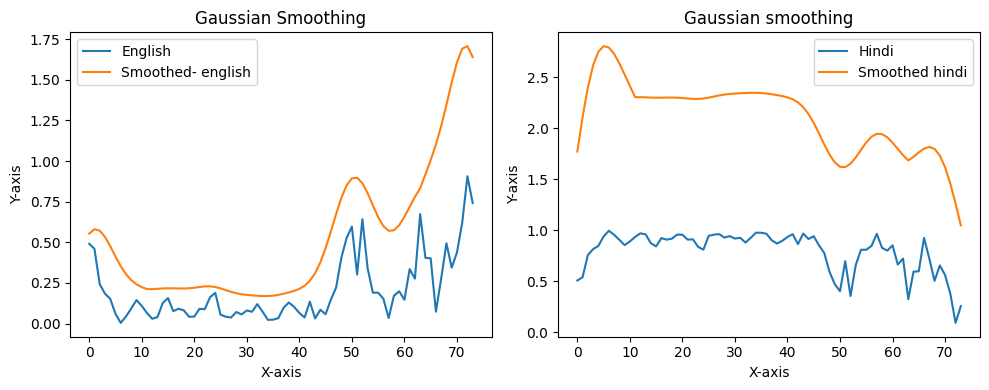

In [68]:
def visualizeSmoothing(S0, S1):
    # Create a figure with two subplots (side by side)
    plt.figure(figsize=(10, 4))

    # Plot the original vectors on the first subplot
    plt.subplot(1, 2, 1)
    plt.plot(S0, label="English")
    plt.plot(gauss_smoothen(S0, sigma, window_size), label="Smoothed- english")
    plt.title("Gaussian Smoothing")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()

    # Plot the smoothed vectors on the second subplot
    plt.subplot(1, 2, 2)
    plt.plot(S1, label="Hindi")
    plt.plot(gauss_smoothen(S1, sigma, window_size), label="Smoothed hindi")
    plt.title("Gaussian smoothing")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()

    # Adjust layout to avoid overlapping labels
    plt.tight_layout()

    # Show the plot
    plt.show()
visualizeSmoothing(S0, S1)

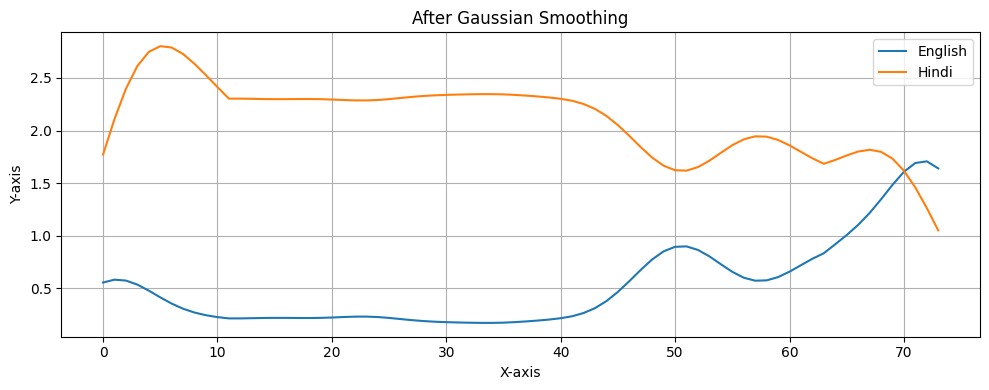

In [69]:
# Create a figure with two subplots (side by side)
plt.figure(figsize=(10, 4))

# Plot the original vectors on the first subplot
plt.plot(gauss_smoothen(S0, sigma, window_size), label="English")
plt.plot(gauss_smoothen(S1, sigma, window_size), label="Hindi")
plt.title("After Gaussian Smoothing")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
# Adjust layout to avoid overlapping labels
plt.tight_layout()
plt.grid()
# Show the plot
plt.show()

#### Visualize the real and calculated CP with labels

### Now, we will use the technique of languauge diarization to find the change points following the research paper

In [70]:
def diarize(S0,S1):
    ## Step 1: gaussian smooth all the input 
    S0  = np.array(gauss_smoothen(S0, sigma, window_size))
    S1 = np.array(gauss_smoothen(S1, sigma, window_size))

    ## Step 2: take signum of signed differece 
    print(f"S0-S1: {S0-S1}")
    x = np.sign(S0 - S1)
    print(f"2. After signum: {x}")
    x1 = []
    ## Step 3: take first order difference
    for i in range(1,len(x)-1):
        x1.append(x[i+1] - x[i])
    x1.append(x[len(x)-1])
    x1 = np.array(x1)
    print(f"2. After firstorder difference:{x1}")
    x = x1
    ## Step 4: Find final cp's and the language labels
    x = 0.50*x
    print(f"3. After 0.5*x: {x}")
    x = np.abs(x)
    print(f"4. After abs: {x}")
    x = np.where(x == 1)
    print("Change points are: ", x)
    SL = []
    for i in range(0, len(S0)):
        if S0[i]>S1[i]:
            SL.append(0)
        else:
            SL.append(1)

    lang_labels = [np.argmax(np.bincount(SL[:math.floor(x[0][0])]))]
    for i in range(len(x[0])-1):
        lang_labels.append(np.argmax(np.bincount(SL[math.floor(x[0][i]):math.floor(x[0][i+1])])))

    if len(x[0])!=1:
        lang_labels.append(np.argmax(np.bincount(SL[math.floor(x[0][len(x[0])-1]):])))
    print("Segment Labels are: ", SL)
    return x, lang_labels

x, lang_labels = diarize(S0, S1)
print(x)
print(lang_labels)

S0-S1: [-1.21741266 -1.52830219 -1.82521818 -2.08043581 -2.27223983 -2.39038097
 -2.43715019 -2.42363694 -2.36677363 -2.28399105 -2.18917841 -2.09147315
 -2.09140782 -2.08758158 -2.08341764 -2.08147562 -2.08185748 -2.08360905
 -2.0843036  -2.08158341 -2.07463721 -2.06541912 -2.05796733 -2.05707557
 -2.06544279 -2.08232824 -2.10384835 -2.12484222 -2.14213193 -2.15444738
 -2.16270307 -2.16889938 -2.17359067 -2.17685555 -2.17689396 -2.17238336
 -2.16236435 -2.14871781 -2.13236293 -2.11327205 -2.0878215  -2.05078742
 -1.98948517 -1.89574049 -1.76189855 -1.58751049 -1.38259228 -1.16755294
 -0.96875122 -0.8147795  -0.7288299  -0.72105457 -0.78846992 -0.9107299
 -1.06051804 -1.20517586 -1.31678328 -1.37386295 -1.36780231 -1.30543663
 -1.20196512 -1.07906388 -0.95633222 -0.85129397 -0.8023175  -0.75750139
 -0.69817585 -0.60175483 -0.45221288 -0.24964461 -0.01038126  0.23387917
  0.4441383   0.59016295]
2. After signum: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -

In [71]:
x = x[0]

In [72]:
x = (x*hop_length_seconds)+0.5
x

array([17.75])

In [73]:
def generate_rttm_file(name,cp, predicted_labels):
    rttm_content = ""
    # Add the start time at 0
    start_time = 0
    tolang = {0:"English",1:"Hindi"}
    for i in range(len(cp)):
        end_time = cp[i]
        # Calculate duration for each segment
        duration = end_time - start_time
        # Generate RTTM content
        rttm_content += f"Language {name} 1 {start_time:.3f} {duration:.3f} <NA> {tolang[predicted_labels[i]]} <NA> <NA>\n"
        # Update start time for the next segment
        start_time = end_time
    
    output_rttm_filename = f"Predicted{name}.rttm"

    # Export RTTM file
    with open(output_rttm_filename, "w") as rttm_file:
        rttm_file.write(rttm_content)
    
    return output_rttm_filename

In [74]:
def extract_gcp(rttm_file_path):
    with open(rttm_file_path, 'r') as file:
        lines = file.readlines()

    gcp = []

    for line in lines:
        # Split the line by whitespace
        parts = line.split()

        # Extract relevant information
        gcp.append(float(parts[3]) + float(parts[4]))
    return gcp[:-1]

Ground Truth of change points: [11.812]
Diralised Change points (Predicted): [17.75]
      Label: Codemixed Hindi English

Duration of the speech:  19.2889375


/var/folders/hw/9s_jqm8d44nfvywkt4hkr0qm0000gn/T/ipykernel_1218/1322633649.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(cp, 0, 'ro', color='blue', marker='o', markersize=8, label='GCP' if i == 0 else "")
/var/folders/hw/9s_jqm8d44nfvywkt4hkr0qm0000gn/T/ipykernel_1218/1322633649.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(cp, 0, 'ro', color='blue', marker='o', markersize=8, label='GCP' if i == 0 else "")


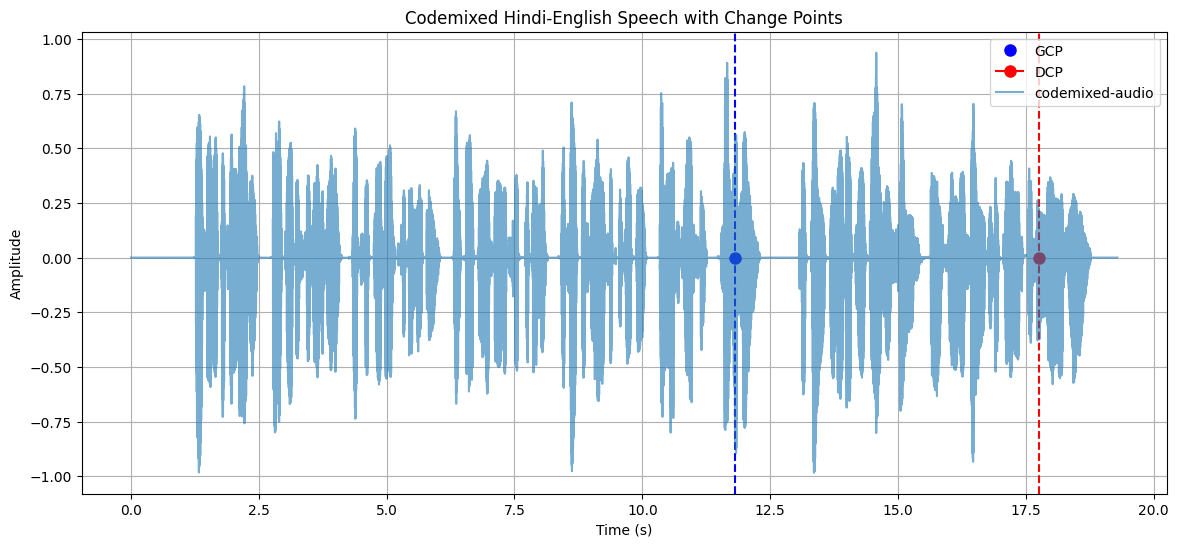

Original sampling Rate:  16000
Duration:  19.2889375
Before:  (308623,) 
After:  (308623,)


In [77]:
def plotCP(audio_path, gcp, dcp):
    print(f"      Label: Codemixed Hindi English")
    print()
    gcp = np.array(gcp)
    dcp = np.array(dcp)
    speech, sr = torchaudio.load(audio_path)
    speech = speech[0].numpy().squeeze()
    print("Duration of the speech: ", len(speech) / sr)
    
    # Create a time vector in seconds
    time = np.arange(0, len(speech)) / sr

    plt.figure(figsize=(14, 6))
    i = 0
    # Add ground truth change points as circles
    for cp in gcp:
        plt.plot(cp, 0, 'ro', color='blue', marker='o', markersize=8, label='GCP' if i == 0 else "")
        plt.axvline(x=cp, color='blue', linestyle='--')
        i = 1

    i = 0
    # Add detected change points as vertical dashed lines
    for cp in dcp:
        plt.plot(cp, 0, marker='o', color='red', markersize=8, label='DCP' if i == 0 else "")
        plt.axvline(x=cp, color='red', linestyle='--')
        i = 1

    # Set plot labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Codemixed Hindi-English Speech with Change Points')

    # Show audio
    plt.plot(time, speech, label='codemixed-audio', alpha=0.6)

    # Show the plot
    plt.legend(loc=1)
    plt.grid()
    plt.show()

    print("Original sampling Rate: ", sr)
    print("Duration: ", len(speech) / sr)
    print("Before: ", speech.shape, "\nAfter: ", speech.shape)
    
    return ipd.Audio(data=np.asarray(speech), autoplay=True, rate=sr)

# gcp = [4, 11, 19]  # Ground truth change points in seconds
ref_rttm = "/Users/yash/Desktop/MTP-2k23-24/Wav2vec-codes/testDiralisationOutput/rttm/rttm_HECodemixedFemale2.rttm"
gcp = extract_gcp(ref_rttm) 
name = audio_path.split("/")[-1].split(".")[0]
sys_rttm = generate_rttm_file(name,x,lang_labels)
# Ground truth change points in seconds
dcp = x  # Detected change points in seconds
print(f"Ground Truth of change points: {gcp}")
print(f"Diralised Change points (Predicted): {dcp}")
plotCP(audio_path, gcp, dcp)

In [83]:
import subprocess
import re

def run_command(command):
    try:
        result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, check=True, text=True)
        return result.stdout.strip()
    except subprocess.CalledProcessError as e:
        print(f"Error running command: {e}")
        return None

# Example command
command = f'python findDER.py -r "{ref_rttm}" -s "{sys_rttm}"'

# Run the command
output = run_command(command)
print(output)

# Extract the 4th integer from the last line of the output
if output:
    lines = output.split('\n')
    last_line = lines[-1].strip()

    # Use regular expression to extract integers
    floats = re.findall(r'-?\d+\.\d+', last_line)

    if len(floats) >= 1:
        der = floats[0]
        print(f"The required DER is : {der}")
    else:
        print("Enable to extract the integers.")
else:
    print("Command execution failed.")


File                  DER    JER    B3-Precision    B3-Recall    B3-F1    GKT(ref, sys)    GKT(sys, ref)    H(ref|sys)    H(sys|ref)    MI    NMI
------------------  -----  -----  --------------  -----------  -------  ---------------  ---------------  ------------  ------------  ----  -----
HECodemixedFemale2  13.88  13.12            0.90         0.85     0.88             0.00             0.00          0.29          0.39  0.01   0.02
*** OVERALL ***     13.88  13.12            0.90         0.85     0.88             0.00             0.00          0.29          0.39  0.01   0.02
The required DER is : 13.88


In [76]:
# dummy = []
# def pipeline(path):
#     ## Step 1: preprocees the audio by removing silence
#     x = preProcessSpeech(path)
#     ## Now, we will just bbreak this audio into multiple overlapping windows 
#     # Calculate the hop size in samples
#     hop_size = int(hop_length_seconds * target_sampling_rate)  # Adjust 'sample_rate' as needed

#     # Generate overlapping frames
#     frames = [x[i:i+window_size] for i in range(0, len(x) - window_size + 1, hop_size)]
#     # frames = [x]
#     S0 = []
#     S1 = []
#     dic = {0: "eng", 1: "hin"}
#     for frame in tqdm(frames):
#         ## Step 2: get the hidden featrue for the processed output
#         x = getHiddenFeatures(frame)
#         ## Step 3: get the output of TDNN for both eng and hindi
#         XX_val = inputTDNN(x)
#         XX_val = torch.unsqueeze(XX_val, 1)
#         X_val = np.swapaxes(XX_val, 0, 1)
#         X_val = Variable(X_val, requires_grad=False)
#         model_xVector.eval()  # Set the model to evaluation mode
#         val_lang_op =model_xVector.forward(X_val)
#         val_lang_op = val_lang_op.detach().cpu().numpy()[0]
#         val_lang_op = np.array([val_lang_op[2], val_lang_op[4]])
#         print("Before Softmax",val_lang_op)
#         y = dic[np.argmax(val_lang_op)]
#         ## apply softmax
#         val_lang_op = np.exp(val_lang_op)/np.sum(np.exp(val_lang_op))
#         print("After softmax: ",val_lang_op)
#         # print(f"Predicted language for this window is: ",y)
#         ## Step 4: mask the output for all languauge except eng and hindi
#         dummy.append(y)
#         # print(val_lang_op)
#         S0.append(val_lang_op[0])
#         S1.append(val_lang_op[1])
#     return np.array(S0), np.array(S1)
